# QUBO formulation of the Redundant Calibration

In [18]:
import numpy as np
np.random.seed(20)

In [19]:
size = 4
A = np.random.rand(size,size)
A = 0.1*(A+A.T)
# A /= np.linalg.norm(A)

In [20]:
b =  np.random.rand(size,1)
# b /= np.linalg.norm(b)

## Classical Solution

The solution of such a small system can be obtained by a least square as implemented in numpy

In [21]:
npsol = np.linalg.solve(A,b)
npsol = np.asarray(npsol).flatten()
print(npsol)

[-0.37072381  6.30320449 -3.71869512  0.92589866]


## 2. QUBO formalism for linear systems

The Quandratic Unconstrainted Binary Optimization problem, or QUBO, allows to minimize the cost function :

$$
E(x) = x^{T}Qx
$$

where the variables $x_i$ are binaries, i.e. the are 0 or 1. The equation above can be rewritten as :

$$
E(x) = \sum_i Q_{ii}x_i + \sum_{ij} Q_{ij}x_ix_j
$$

that is very similar to the Ising model, basis of the quantum annealler architecture. 

### Encoding real numbers in binary variables

In the QUBO problems, variables are binaries and we of course want to solve for real numbers in our case. There ar e different ways to encode real numbers in multiple binaries. In our case since the variables are between -1.0 and 1.0 we can use the following encoding : 

$$
r_i = a \sum_n x_n 2^{n} - x_{k+n} 2^{n} 
$$

where $a$ is a normalization constant. THis encoding is created in the `SolutionVector` class that allows to encode/decode real numbers in a series of binaries variables. We use here the `RealUnitQbitEncoding` to obtain real numbers between -1 and 1. The number of qbit controls the precision of the reals we can obtain.

### Linear systems

To solve a linear system $Ax=b$ with QUBO we need to minimize the following loss 

$$
E(x) = ||Ax-b||^2 =(Ax-b)^T (Ax-b) = x^T A^T A x-b^T A x-A x b^T+ b^T b = x^T Q x + ||b||^2
$$

We can ignore the last terms as it doesn't contribute to the optimization process. The $Q$ matrix can be defined through the different terms of the expression. This is achieved by the `create_qubo_matrix` methods that returns a `dict` containing the weights (diagonal terms) and strengths (off diagonal terms) of the $Q$ matrix. 

## 3. Solving the system

We will use here the `SimulatedAnnealingSampler` to be able to run that code locally. Quantum solvers are available through the Leap cloud service.

In [22]:
from qubols.qubols import QUBOLS
from qubols.encodings import RangedEfficientEncoding
options = {'num_reads':100, 'num_qbits':21, 'encoding': RangedEfficientEncoding, 'range':1.0, 'offset':[0,6,-3,1]}
qubols= QUBOLS(options)
sol_num = qubols.solve(A, b)

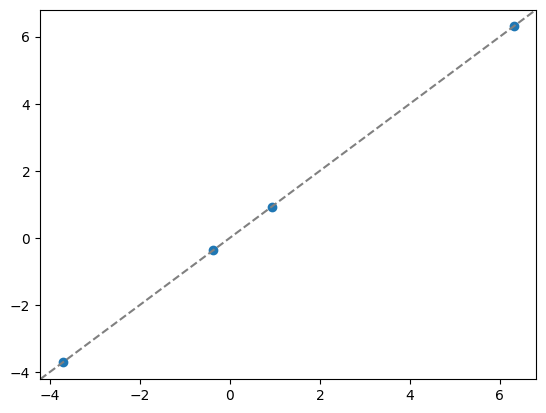

In [23]:
import matplotlib.pyplot as plt
plt.scatter(npsol, sol_num)
plt.axline( (0,0),slope=1,linestyle='--',color='gray')

In [7]:
from qubols.aequbols import AEQUBOLS

In [24]:
options = {'num_reads':20, 'iterations':3, 'num_qbits':21, 'encoding': RangedEfficientEncoding, 'range':10.0, 'offset':0.0}
qubols= AEQUBOLS(options)
sol_num = qubols.solve(A, b)

x [0.0, 0.0, 0.0, 0.0] 10.0
x [-1.3496898171327762, 4.1743280165939485, -0.5000014305128391, 0.9937114655604029] [7.187506854540688, 6.425787378108387, 8.750017881410487, 2.508556850964406]
x [-1.232825956070144, 5.327355382880949, -1.9902636372338542, 1.1922885938249386] [7.187520563635134, 3.2129028812255376, 6.562528014239605, 2.2341855760755758]


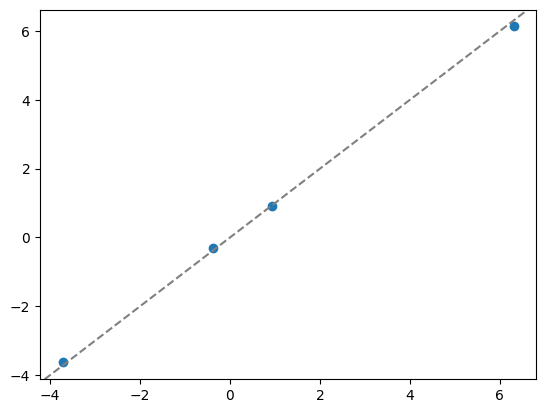

In [25]:
import matplotlib.pyplot as plt
plt.scatter(npsol, sol_num)
plt.axline( (0,0),slope=1,linestyle='--',color='gray')